In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/Users/anuragsharma/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [5]:
ratings.shape

(6031, 4)

That's all we need to create and train a model:

In [8]:
ratings.describe()

,userId,movieId,rating,timestamp
count,6031.000000,6031.000000,6031.000000,6.031000e+03
mean,350.269773,1892.725419,3.807826,1.127659e+09
std,194.409989,4483.290497,0.961857,1.591801e+08
min,15.000000,1.000000,0.500000,8.538928e+08
25%,176.000000,457.000000,3.000000,9.764243e+08
50%,358.000000,1089.000000,4.000000,1.111489e+09
75%,518.000000,2028.000000,4.500000,1.232810e+09
max,665.000000,58559.000000,5.000000,1.473804e+09


In [6]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [9]:
y_range = [0,5]

In [12]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


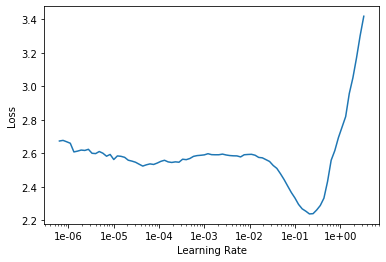

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(3, 5e-2)

epoch,train_loss,valid_loss,time
0,1.308319,1.038836,00:00
1,1.097408,1.132339,00:00
2,0.666329,0.979841,00:00


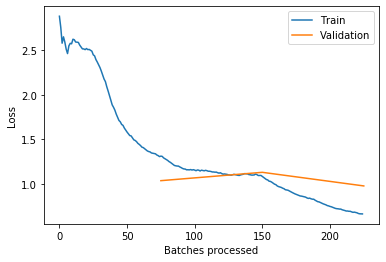

In [15]:
learn.recorder.plot_losses()

## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [18]:
path=Config.data_path()/'ml-100k'

In [19]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [20]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
len(ratings)

100000

In [22]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [24]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [25]:
data.show_batch()

userId,title,target
424,Last Man Standing (1996),4.0
906,Leaving Las Vegas (1995),5.0
752,Dante's Peak (1997),1.0
838,Mary Poppins (1964),5.0
532,Twister (1996),4.0


In [41]:
y_range = [0,5]

In [48]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1, metrics=mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


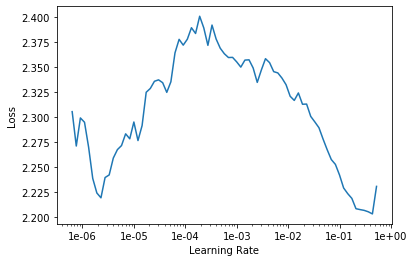

In [49]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [50]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.987550,1.009862,1.009862,00:08
1,1.238356,1.253178,1.253178,00:07
2,1.459425,1.491384,1.491384,00:06
3,1.428073,1.421345,1.421345,00:08
4,1.330092,1.319987,1.319987,00:07
5,1.189284,1.167060,1.167060,00:06
6,0.978126,1.010833,1.010833,00:06
7,0.881053,0.902182,0.902182,00:06
8,0.720728,0.836369,0.836369,00:06
9,0.560918,0.832927,0.832927,00:07


In [52]:
learn.save('dotprod')

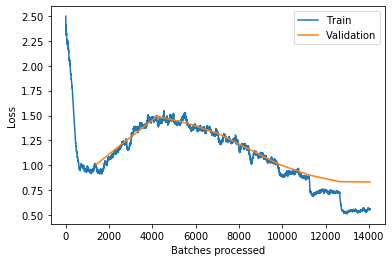

In [55]:
learn.recorder.plot_losses()

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [53]:
learn.load('dotprod');

In [56]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [60]:
g = rating_movie.groupby(title)['rating'].count()

In [62]:
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [63]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [64]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [67]:
movie_ratings

[(tensor(0.8655), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.6752), 'Contact (1997)', 3.8035363457760316),
 (tensor(0.6967), 'Fargo (1996)', 4.155511811023622),
 (tensor(0.6519), 'Return of the Jedi (1983)', 4.007889546351085),
 (tensor(0.2410), 'Liar Liar (1997)', 3.156701030927835),
 (tensor(0.3570), 'English Patient, The (1996)', 3.656964656964657),
 (tensor(0.3960), 'Scream (1996)', 3.4414225941422596),
 (tensor(0.5241), 'Toy Story (1995)', 3.8783185840707963),
 (tensor(0.5191), 'Air Force One (1997)', 3.6310904872389793),
 (tensor(0.3396), 'Independence Day (ID4) (1996)', 3.438228438228438),
 (tensor(0.7447), 'Raiders of the Lost Ark (1981)', 4.252380952380952),
 (tensor(0.7920), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.5626), 'Pulp Fiction (1994)', 4.060913705583756),
 (tensor(0.4738), 'Twelve Monkeys (1995)', 3.798469387755102),
 (tensor(0.8570), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4605), 'Jerry Maguire (1996)', 3.7109375),
 

In [68]:
item0 = lambda o:o[0]

In [69]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.4975),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.4541),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3996), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.3648), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.3615), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.3331), 'Grease 2 (1982)', 2.0),
 (tensor(-0.3193), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.3179), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.3080), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.3052), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2961), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2905), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2794), 'Tales from the Hood (1995)', 2.037037037037037),
 (tensor(-0.2769), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2702), 'Home Alone 3 (1997)',

In [70]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.9488), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.9097), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.8927), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.8655), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.8570), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.8449), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.8301), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.8275), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.8147), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.8064), 'Apt Pupil (1998)', 4.1),
 (tensor(0.7972), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.7931), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.7920), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.7899), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.7852), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667)]

### Movie weights

In [71]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [75]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [76]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [77]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2300), 'Chinatown (1974)'),
 (tensor(1.2191), 'Wrong Trousers, The (1993)'),
 (tensor(1.1866), 'Close Shave, A (1995)'),
 (tensor(1.1531),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(1.1346), 'Casablanca (1942)'),
 (tensor(1.1194), 'Lawrence of Arabia (1962)'),
 (tensor(1.0679), 'Citizen Kane (1941)'),
 (tensor(1.0527), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(1.0521), 'Fargo (1996)'),
 (tensor(1.0241), 'North by Northwest (1959)')]

In [78]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2552), 'Jungle2Jungle (1997)'),
 (tensor(-1.1902), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.1053), 'Home Alone 3 (1997)'),
 (tensor(-1.0512), "McHale's Navy (1997)"),
 (tensor(-0.9994), 'Bio-Dome (1996)'),
 (tensor(-0.9942), 'Relic, The (1997)'),
 (tensor(-0.9934), 'Congo (1995)'),
 (tensor(-0.9514), 'Batman & Robin (1997)'),
 (tensor(-0.8898), 'Leave It to Beaver (1997)'),
 (tensor(-0.8879), "Dante's Peak (1997)")]

In [79]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [80]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8886), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8698), 'Keys to Tulsa (1997)'),
 (tensor(0.8401), 'Canadian Bacon (1994)'),
 (tensor(0.8389), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7970), 'Stupids, The (1996)'),
 (tensor(0.7874), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7477), 'Lost Highway (1997)'),
 (tensor(0.7469), 'Trainspotting (1996)'),
 (tensor(0.7456), 'Dead Man (1995)'),
 (tensor(0.7161), 'Sweet Hereafter, The (1997)')]

In [81]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.4434), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.4128), 'Braveheart (1995)'),
 (tensor(-1.1097), 'Titanic (1997)'),
 (tensor(-1.0753), "It's a Wonderful Life (1946)"),
 (tensor(-1.0108), 'Forrest Gump (1994)'),
 (tensor(-1.0073), 'Star Wars (1977)'),
 (tensor(-0.9978), 'Shawshank Redemption, The (1994)'),
 (tensor(-0.9666), 'Indiana Jones and the Last Crusade (1989)'),
 (tensor(-0.9568), "Schindler's List (1993)"),
 (tensor(-0.9254), 'Empire Strikes Back, The (1980)')]

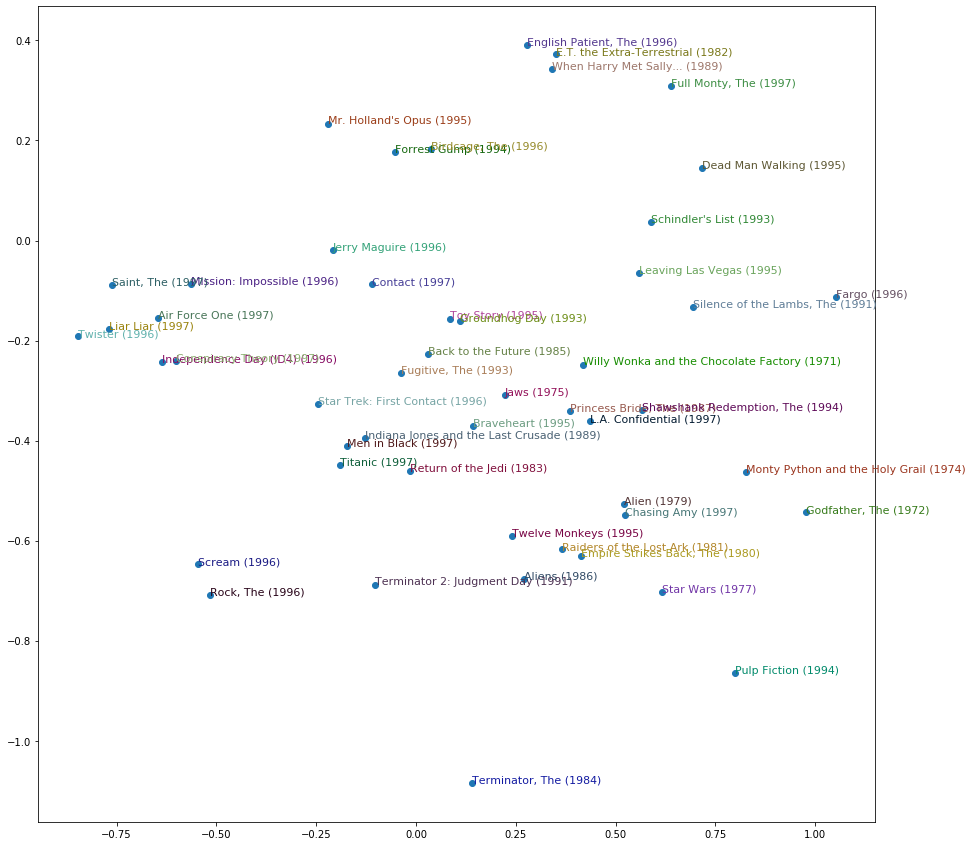

In [82]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()